In [1]:
from imports import *

In [7]:
def compute_state_vector(t,states,useless):

    for u in useless: states.pop(u)

    vector = np.empty(len(t),'object')
    for state,interval in states.items():
        vector[interval.in_interval(t) >= 0] = state
    return vector

def compute_cv(neurons,metadata,stru,types,start = 0,stop = None,binSize = 1,nbins = None):
    activity = bk.compute.binSpikes(neurons[(metadata.Region == stru) & (metadata.Type == types)], start=start, stop=stop,binSize = binSize,nbins = nbins, as_Tsd=True)
    
    cv = (np.std(activity.values,1) / np.mean(activity.values,1))*100
    cv = nts.Tsd(activity.times(),cv)

    return cv

def compute_sync(neurons, metadata, stru,types = 'Pyr', start=0, stop=None, binSize=0.025, window_size = 10): 
    
    if types == 'Pyr' : activity = bk.compute.binSpikes(neurons[(metadata.Region == stru)& (metadata.Type == 'Pyr')], start=start, stop=stop,binSize = binSize, as_Tsd=True)
    if types == 'Int' : activity = bk.compute.binSpikes(neurons[(metadata.Region == stru)& (metadata.Type == 'Int')], start=start, stop=stop,binSize = binSize, as_Tsd=True)
    if types == 'both' : activity = bk.compute.binSpikes(neurons[(metadata.Region == stru)], start=start, stop=stop,binSize = binSize, as_Tsd=True)
    
    activity = bk.compute.binSpikes(neurons[(metadata.Region == stru)], start=start, stop=stop,binSize = binSize, as_Tsd=True)
    #
    # bins = np.linspace(start,stop,nbins+1)
    bins = np.arange(start,activity.times()[-1],window_size*1_000_000)
    sync = []
    times = []
    for s,e in zip(bins,np.roll(bins,-1)):
        if e-s<0: continue
        sync_ = np.corrcoef(activity.restrict(nts.IntervalSet(s,e)),rowvar=False)
        np.fill_diagonal(sync_,np.nan)
        sync.append(np.nanmean(sync_))
        times.append((e+s)/2)
    return nts.Tsd(np.array(times),np.hstack(sync))


# def compute_sync(neurons, metadata, stru, types, start=0, stop=None, binSize=0.025, nbins=None ): 
#     """
#     This function compute sync value between two time point for a structure of interest
#     """
#     # Check what type of neurons we are working with and bin the spikes only of those.
#     if types == 'Pyr' : activity = bk.compute.binSpikes(neurons[(metadata.Region == stru)& (metadata.Type == 'Pyr')], start=start, stop=stop,binSize = binSize, as_Tsd=True)
#     if types == 'Int' : activity = bk.compute.binSpikes(neurons[(metadata.Region == stru)& (metadata.Type == 'Int')], start=start, stop=stop,binSize = binSize, as_Tsd=True)
#     if types == 'both' : activity = bk.compute.binSpikes(neurons[(metadata.Region == stru)], start=start, stop=stop,binSize = binSize, as_Tsd=True)
    
#     # Compute the corr matrix and then compute the synchrony as the average of the pairwise correlation matrix of the binspikes matrices
#     corr = np.corrcoef(activity,rowvar=False)
#     np.fill_diagonal(corr,np.nan)
#     sync = np.nanmean(corr)
#     return sync



# def compute_sync_moving_window(neurons, metadata, stru, types, start=0, stop=None, binSize=0.025, window_size=10, step=1):

#     """
#     This function compute sync value between two time point for a structure of interest
#     """
#     #Check what type of neurons we are working with and bin the spikes only of those.
#     if types == 'Pyr':
#         activity = bk.compute.binSpikes(neurons[(metadata.Region == stru) & (metadata.Type == 'Pyr')], start=start, stop=stop, binSize=binSize, as_Tsd=True)
#     if types == 'Int':
#         activity = bk.compute.binSpikes(neurons[(metadata.Region == stru) & (metadata.Type == 'Int')], start=start, stop=stop, binSize=binSize, as_Tsd=True)
#     if types == 'both':
#         activity = bk.compute.binSpikes(neurons[(metadata.Region == stru)], start=start, stop=stop, binSize=binSize, as_Tsd=True)

#     #Compute the corr matrix and then compute the synchrony as the average of the pairwise correlation matrix of the binspikes matrices

#     bins = np.arange(start,activity.times('s')[-1],step)
#     sync = []
#     t = []
#     for s,e in tqdm(zip(bins,bins+window_size),total = len(bins)):
#         if e>activity.times('s')[-1]: continue 
#         sync_ = compute_sync(neurons,metadata,start = s,stop = e,binSize = binSize,stru = stru,types = types)
#         sync.append(sync_)
#         t.append((s+e)/2)
#     sync = nts.Tsd(np.array(t),np.array(sync),time_units='s')
#     return sync



def compute_eib(neurons, metadata, stru, start=0, stop=None, binSize=0.025, nbins=None,as_tsd = False):
    activity = bk.compute.binSpikes(neurons, start=start, stop=stop,binSize = binSize, nbins=nbins, as_Tsd=True)
    masks = {}
    masks['STRU_PYR'] = (metadata.Region == stru) & (metadata.Type == 'Pyr')
    masks['STRU_INT'] = (metadata.Region == stru) & (metadata.Type == 'Int')
    e_spikes = np.sum(activity.loc[:, masks['STRU_PYR']].values, 1)
    i_spikes = np.sum(activity.loc[:, masks['STRU_INT']].values, 1)
    
    eib = e_spikes / (e_spikes + i_spikes)
    # eib[~np.isfinite(eib)] = np.nan
    
    if as_tsd: eib = nts.Tsd(activity.times(),eib)
    return eib

def compute_fr(neurons, metadata, stru, types,start=0, stop=None, binSize=0.025, nbins=None,as_tsd = False):
    activity = bk.compute.binSpikes(neurons[(metadata.Region == stru) & (metadata.Type == types)], start=start, stop=stop,binSize = binSize, nbins=nbins, as_Tsd=True)
    fr = np.nanmean(activity.values/binSize,1)
    fr = nts.Tsd(activity.times(),fr)
    return fr

In [8]:
def average_by_epochs(tsd,epochs):
    values = []
    for i, epoch in enumerate(epochs.iloc):
        start = epoch.start
        end = epoch.end
        inter = nts.IntervalSet(start,end)

        values.append(np.nanmean(tsd.restrict(inter)))
    return np.hstack(values)

In [10]:
def main(base_folder,local_path,*args,**kwargs):
      bk.load.current_session_linux(base_folder,local_path)
      neurons, metadata = bk.load.spikes()
      states = bk.load.states(True)
      win = 10
      cv = compute_cv(neurons,metadata,'BLA','Pyr',binSize = win)
      sync = compute_sync(neurons,metadata,'BLA',binSize=0.100,window_size=win)
      eib = compute_eib(neurons, metadata, 'BLA', start=0, stop=None, binSize=win, nbins=None,as_tsd = True)
      fr = {}
      fr['Pyr'] = compute_fr(neurons, metadata, 'BLA','Pyr', start=0, stop=None, binSize=win, nbins=None,as_tsd = True)
      fr['Int'] = compute_fr(neurons, metadata, 'BLA','Int', start=0, stop=None, binSize=win, nbins=None,as_tsd = True)
      
      state_vector = compute_state_vector(cv,states,['wake','drowsy'])
      df = {'CV': cv,
      'Sync': sync,
      'EIB':eib,
      'FR_Pyr':fr['Pyr'],
      'FR_Int':fr['Int'],
      'State':state_vector}
      df = pd.DataFrame(data=df)
      df = nts.TsdFrame(df,time_units='us')
      os.makedirs('Analysis/NetworkProperties',exist_ok=True)
      df.to_csv('Analysis/NetworkProperties/sync_cv_eib_fr_1s.csv')
      return df


      cv_z = bk.compute.nts_zscore(cv)
      sync_z = bk.compute.nts_zscore(sync)
      eib_z = bk.compute.nts_zscore(eib)
      fr_z = {}
      fr_z['Pyr'] = bk.compute.nts_zscore(fr['Pyr'])
      fr_z['Int'] = bk.compute.nts_zscore(fr['Int'])



      cv_z_smooth = bk.compute.nts_smooth(cv_z,1000,1)
      sync_z_smooth = bk.compute.nts_smooth(sync_z,1000,1)
      eib_z_smooth = bk.compute.nts_smooth(eib_z,1000,1)
      fr_z_smooth = {}
      fr_z_smooth['Pyr'] = bk.compute.nts_smooth(fr_z['Pyr'],1000,1)
      fr_z_smooth['Int'] = bk.compute.nts_smooth(fr_z['Int'],1000,1)

      df = {'CV': cv_z_smooth,
            'Sync': sync_z_smooth,
            'EIB':eib_z_smooth,
            'FR_Pyr':fr_z_smooth['Pyr'],
            'FR_Int':fr_z_smooth['Int'],
            'State':state_vector}
      df = pd.DataFrame(data=df)

      # fig,ax = plt.subplots(2,3)
      # ax = np.ravel(ax)

      # for i,col in enumerate(df.columns):
      #       if col == 'State': continue
      #       sns.violinplot(data = df,y = col,x = 'State',ax = ax[i])
      #       ax[i].set_title(col)


      return df

In [11]:
batch,metadata = bk.load.batch(main)

100%|██████████| 61/61 [1:22:12<00:00, 80.86s/it]

['Rat08-20130708', 'Rat08-20130718', 'Rat08-20130719', 'Rat08-20130720', 'Rat08-20130722', 'Rat09-20140404', 'Rat09-20140405', 'Rat09-20140407', 'Rat09-20140408', 'Rat09-20140409', 'Rat10-20140619', 'Rat10-20140620', 'Rat10-20140702', 'Rat10-20140705', 'Rat10-20140707', 'Rat10-20140708', 'Rat11-20150310', 'Rat11-20150312', 'Rat11-20150313', 'Rat11-20150314', 'Rat11-20150315', 'Rat11-20150316', 'Rat11-20150317', 'Rat11-20150401', 'Rat11-20150402', 'Rat11-20150403']
Batch finished in 4932.686370849609
Some session were not processed correctly
['Rat08-20130708', 'Rat08-20130718', 'Rat08-20130719', 'Rat08-20130720', 'Rat08-20130722', 'Rat09-20140404', 'Rat09-20140405', 'Rat09-20140407', 'Rat09-20140408', 'Rat09-20140409', 'Rat10-20140619', 'Rat10-20140620', 'Rat10-20140702', 'Rat10-20140705', 'Rat10-20140707', 'Rat10-20140708', 'Rat11-20150310', 'Rat11-20150312', 'Rat11-20150313', 'Rat11-20150314', 'Rat11-20150315', 'Rat11-20150316', 'Rat11-20150317', 'Rat11-20150401', 'Rat11-20150402', 'R

In [5]:
def load(base_folder,local_path,*args,**kwargs):
    bk.load.current_session_linux(base_folder,local_path)
    states = bk.load.states(True)
    df = pd.read_csv('Analysis/NetworkProperties/sync_cv_eib_fr_10s.csv',index_col='Time (us)')
    df = nts.TsdFrame(df,time_units='us')

    df_ = df.drop(columns='State')
    columns = df_.columns
    # df_ = bk.compute.nts_zscore(df_)
    df_.columns = columns
    df_['State'] = df['State']
    by_epochs = {}
    for state in ['REM','NREM','WAKE_HOMECAGE']:
        by_epochs[state] = {}
        for metric in df.drop(columns='State').columns:
            by_epochs[state][metric] = average_by_epochs(df_[metric],states[state])
    df = pd.DataFrame(by_epochs).T
    df_exploded = df.explode([c for c in df.columns]).astype(np.float64)
    df_exploded.index.name = 'State'
    df_exploded.reset_index(inplace=True)
    return df_exploded# df_.as_dataframe().groupby('State').mean()

In [6]:
batch, metadata = bk.load.batch(load)

100%|██████████| 61/61 [00:18<00:00,  3.39it/s]

Batch finished in 18.089768409729004
Some session were not processed correctly
['Rat08-20130708', 'Rat08-20130718', 'Rat08-20130719', 'Rat08-20130720', 'Rat08-20130722', 'Rat09-20140404', 'Rat09-20140405', 'Rat09-20140407', 'Rat09-20140408', 'Rat09-20140409', 'Rat10-20140619', 'Rat10-20140620', 'Rat10-20140702', 'Rat10-20140705', 'Rat10-20140707', 'Rat10-20140708', 'Rat11-20150310', 'Rat11-20150312', 'Rat11-20150313', 'Rat11-20150314', 'Rat11-20150315', 'Rat11-20150316', 'Rat11-20150317', 'Rat11-20150401', 'Rat11-20150402', 'Rat11-20150403']
42.62295081967213 %


In [361]:
def multi_mannwhitneyu(values,n = None):
    """
    This function compute pairwise manvhitneyu and correct with the bonferoni correction
    """

    if n is None:
        n = len(values)
    stats = []

    for i in itertools.combinations(values.keys(),2):
        f,pvalue = scipy.stats.mannwhitneyu(values[i[0]],values[i[1]])
        stat = {'Name':['-'.join(i)],
                'Statistic':f,
                'pValue':pvalue,
                'p-Ajusted':pvalue*n}
        stats.append(pd.DataFrame(stat))
    return pd.concat(stats)

In [364]:
values_states = {}
for state in np.unique(all_batch_zscore.State): values_states[state] = all_batch_zscore[all_batch_zscore.State == state]['Sync'].dropna().values
print(scipy.stats.kruskal(values_states['NREM'],values_states['REM'],values_states['WAKE_HOMECAGE']))
multi_mannwhitneyu(values_states)

KruskalResult(statistic=461.89892465047706, pvalue=5.010982818224899e-101)


,Name,Statistic,pValue,p-Ajusted
0,NREM-REM,256149.0,3.424071e-76,1.027221e-75
0,NREM-WAKE_HOMECAGE,271324.0,7.433525e-63,2.230058e-62
0,REM-WAKE_HOMECAGE,79843.0,4.891493e-07,1.467448e-06


In [360]:
all_batch_zscore

,level_0,level_1,State,CV,Sync,EIB,FR_Pyr,FR_Int
0,Rat08-20130709,0,REM,178.782115,0.008788,0.191925,0.535981,13.411688
1,Rat08-20130709,1,REM,155.996673,0.006436,0.214108,0.612313,13.407955
2,Rat08-20130709,2,REM,193.240471,0.007038,0.166328,0.449411,13.051196
3,Rat08-20130709,3,REM,164.015417,0.006611,0.214902,0.676418,14.972727
4,Rat08-20130709,4,REM,200.030853,0.008509,0.200029,0.523561,12.703247
...,...,...,...,...,...,...,...,...
1627,Rat11-20150331,44,WAKE_HOMECAGE,98.975780,0.006045,0.697877,0.951582,6.296610
1628,Rat11-20150331,45,WAKE_HOMECAGE,94.357112,0.004195,0.713088,0.974762,6.092857
1629,Rat11-20150331,46,WAKE_HOMECAGE,131.607484,0.005854,0.787723,0.855833,3.462500
1630,Rat11-20150331,47,WAKE_HOMECAGE,118.761989,0.005532,0.569886,0.741111,8.573810


In [343]:
all_batch = pd.concat(batch)
all_batch.reset_index(inplace=True)

/home/billel/anaconda3/lib/python3.9/site-packages/seaborn/categorical.py:1296: UserWarning: 22.0% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/home/billel/anaconda3/lib/python3.9/site-packages/seaborn/categorical.py:1296: UserWarning: 26.6% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


<AxesSubplot:xlabel='State', ylabel='Sync'>

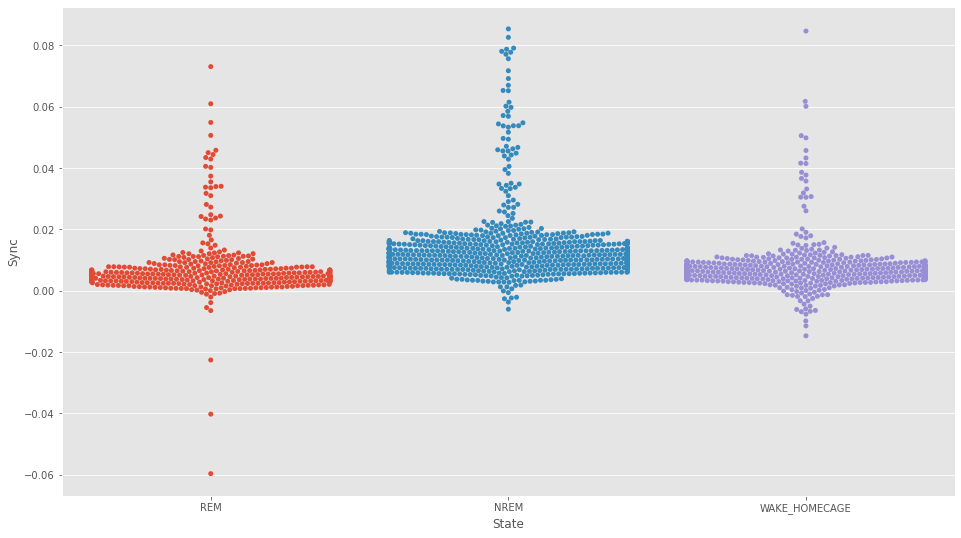

In [365]:
plt.figure(figsize=(16,9))
sns.swarmplot(data = all_batch_zscore,x = 'State',y = 'Sync')

In [302]:
from scipy.stats import bartlett
from scipy.stats import shapiro
from scipy.stats import levene

import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.formula.api import glm
from statsmodels.formula.api import gls
from statsmodels.stats.anova import anova_lm
from statsmodels.graphics.factorplots import interaction_plot
from statsmodels.stats.multicomp import pairwise_tukeyhsd

def anova(df, formula):
    lm = ols(formula, df).fit()
    anova_table = anova_lm(lm)
    print(anova_table)

    levene(df.EIB[df.State == 'NREM'],
           df.EIB[df.State == 'REM'],
           df.EIB[df.State == 'WAKE_HOMECAGE'])
    bartlett(df.EIB[df.State == 'NREM'],df.EIB[df.State == 'REM'])
    
    fig, ax = plt.subplot_mosaic('''
                                AAABBB
                                FFFGGG
                                CCDDEE''', dpi=180, figsize=(12, 12))
    sns.stripplot(data=df, x='State', y='EIB', ax=ax['A'],alpha = 0.65,s = 3)
    ax['A'].set_title('BOX PLOT EIB')
    ax['A'].set_ylim(-3,3)
    sm.qqplot(lm.resid, fit=True, line='45', ax=ax['B'])
    ax['B'].set_title('QQPlot Residuals')

    # sns.boxplot(data=df, x='Rat', y='EIB', ax=ax['F'])
    # sns.boxplot(data=df, x='Day', y='EIB', ax=ax['G'])

    for ax_, data in zip(['C', 'D', 'E'], np.unique(df.State)):
        sm.qqplot(df.EIB[df.State == data], ax=ax[ax_], fit=True, line='45')
        ax[ax_].set_title(f'QQPlot {data}')
    plt.tight_layout()

    m_comp = pairwise_tukeyhsd(df['EIB'], df['State'], alpha=0.05)
    print(m_comp.summary())
    print(m_comp.pvalues)

In [312]:
df.dropna(inplace=True)

In [313]:
m_comp = pairwise_tukeyhsd(df['EIB'], df['State'], alpha=0.05)
m_comp.summary()

group1,group2,meandiff,p-adj,lower,upper,reject
NREM,REM,-0.0935,0.0977,-0.1997,0.0127,False
NREM,WAKE_HOMECAGE,-0.3699,-0.0,-0.4733,-0.2666,True
REM,WAKE_HOMECAGE,-0.2765,0.0,-0.3931,-0.1598,True


              df      sum_sq    mean_sq          F        PR(>F)
C(State)     2.0   30.370675  15.185337  28.251533  8.677262e-13
Residual  1630.0  876.133002   0.537505        NaN           NaN


RuntimeError: The data contains non-finite values.

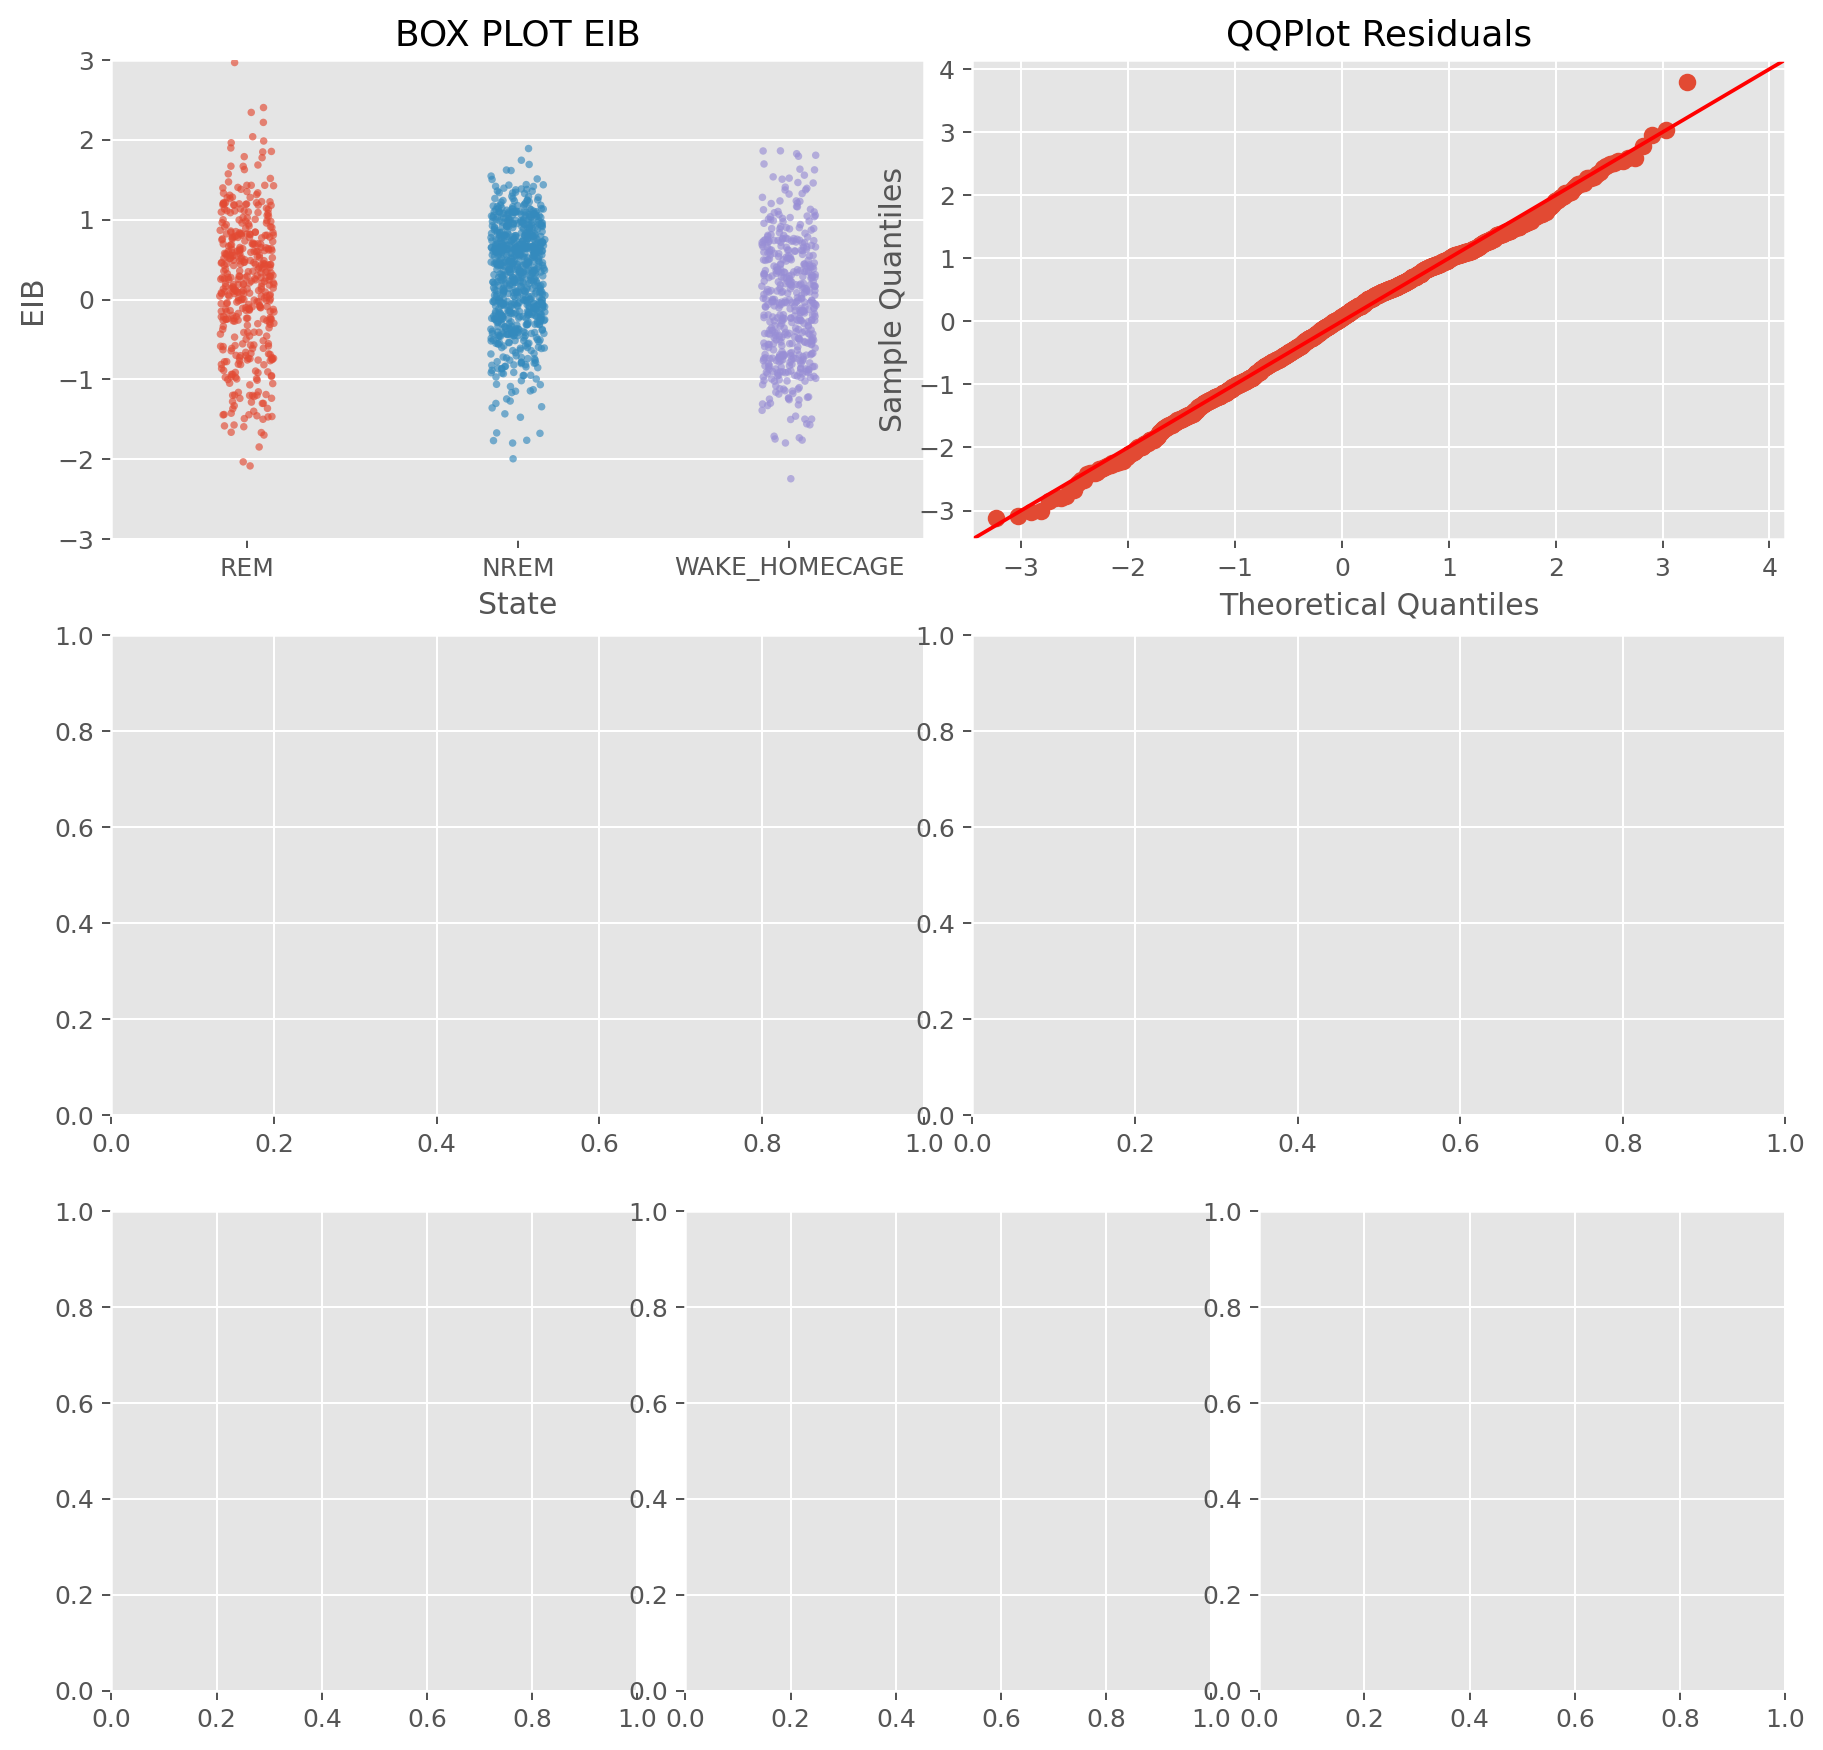

In [338]:
formula = 'EIB ~ C(State)'
anova(all_batch,formula)
# plt.savefig('/home/billel/pCloudDrive/IFM/work/Figures/Ongoing/EIB/EIB_Strip.svg')

<AxesSubplot:xlabel='State', ylabel='EIB'>

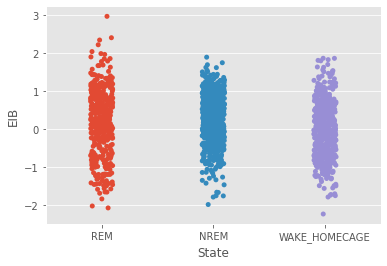

In [306]:
sns.stripplot(data = all_batch,x = 'State',y = 'EIB')

<AxesSubplot:xlabel='State', ylabel='FR_Int'>

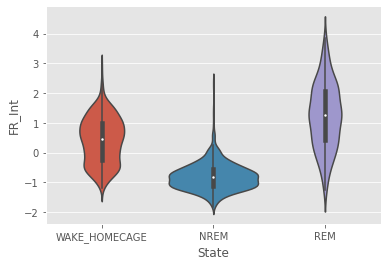

In [107]:
sns.violinplot(data=df_.as_dataframe(),y = 'FR_Int',x = 'State')

<AxesSubplot:xlabel='State', ylabel='FR_Pyr'>

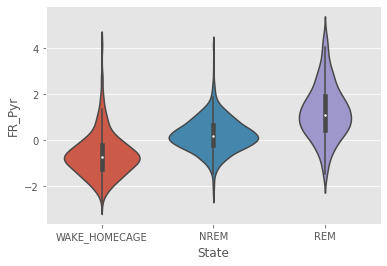

In [106]:
sns.violinplot(data=df_.as_dataframe(),y = 'FR_Pyr',x = 'State')

<AxesSubplot:xlabel='State', ylabel='CV'>

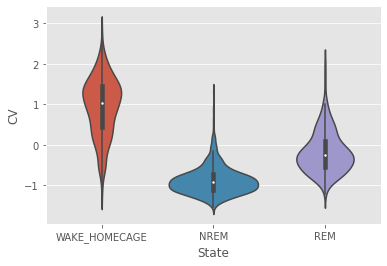

In [356]:
sns.violinplot(data=df_.as_dataframe(),y = 'CV',x = 'State')

<AxesSubplot:xlabel='State', ylabel='Sync'>

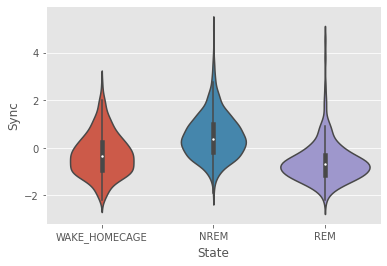

In [357]:
sns.violinplot(data=df_.as_dataframe(),y = 'Sync',x = 'State')

<AxesSubplot:xlabel='State', ylabel='EIB'>

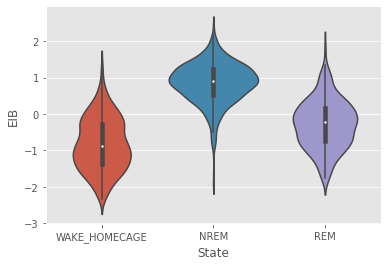

In [103]:
sns.violinplot(data=df_.as_dataframe(),y = 'EIB',x = 'State')

Rat : 8 on day : 6
Working with session Rat08-20130713 @ /mnt/electrophy/Gabrielle/GG-Dataset-Light/Rat08/Rat08-20130713
Data already saved in Numpy format, loading them from here:
Rat08-20130713-neurons.npy
Rat08-20130713-metadata.npy


In [4]:
df = pd.concat(batch)
df = df.reset_index()

NameError: name 'batch' is not defined

NameError: name 'df' is not defined

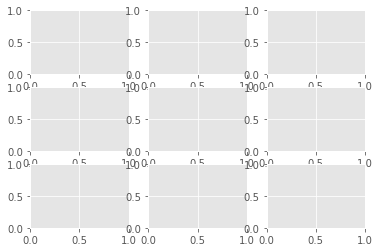

In [5]:
fig,ax = plt.subplots(3,3)
ax = np.ravel(ax)

for i,col in enumerate(df.columns):
      if col == 'State': continue
      if col == 'level_0':continue
      sns.violinplot(data = df,x = 'State',y = col,ax = ax[i])
      ax[i].set_title(col)
plt.tight_layout()

In [17]:
def main(base_folder,local_path,*args,**kwargs):

    stru = kwargs['stru']
    types = kwargs['types'] #Only for cv and sync
    binSize = kwargs['binSize']
    binSize_sync = kwargs['binSize_sync']

    bk.load.current_session_linux(base_folder,local_path)
    neurons, metadata = bk.load.spikes()
    states = bk.load.states(True)


    fr = {}
    fr['Pyr'] = compute_fr(neurons, metadata, stru,'Pyr', start=0, stop=None, binSize=binSize, nbins=None,as_tsd = True)
    fr['Int'] = compute_fr(neurons, metadata, stru,'Int', start=0, stop=None, binSize=binSize, nbins=None,as_tsd = True)
    cv,m,std = compute_cv(neurons,metadata,stru,types,binSize = binSize)
    sync = compute_sync(neurons,metadata,stru,types,binSize=binSize_sync,window_size=binSize)
    eib = compute_eib(neurons, metadata, stru, start=0, stop=None, binSize=binSize, nbins=None,as_tsd = True)
    eib_z = bk.compute.nts_zscore(eib)



    cv_z = bk.compute.nts_zscore(cv)
    sync_z = bk.compute.nts_zscore(sync)
    fr_z = {}
    fr_z['Pyr'] = bk.compute.nts_zscore(fr['Pyr'])
    fr_z['Int'] = bk.compute.nts_zscore(fr['Int'])


    state_vector = compute_state_vector(cv,states,['wake','drowsy'])

    cv_z_smooth = bk.compute.nts_smooth(cv_z,1000,1)
    sync_z_smooth = bk.compute.nts_smooth(sync_z,1000,1)
    eib_z_smooth = bk.compute.nts_smooth(eib_z,1000,1)
    fr_z_smooth = {}
    fr_z_smooth['Pyr'] = bk.compute.nts_smooth(fr_z['Pyr'],1000,1)
    fr_z_smooth['Int'] = bk.compute.nts_smooth(fr_z['Int'],1000,1)

    # df = {'CV': cv_z_smooth,
    #     'Sync': sync_z_smooth,
    #     'EIB':eib_z_smooth,
    #     'FR_Pyr':fr_z_smooth['Pyr'],
    #     'FR_Int':fr_z_smooth['Int'],
    #     'State':state_vector}
    # df = pd.DataFrame(data=df)
    # df = nts.TsdFrame(df.index.values,df)


    values_by_states = {}
    df = []
    for value_name,values in zip(['FR_Pyr','FR_Int','cv','eib','sync'],[fr_z['Pyr'],fr_z['Int'],cv,eib_z,sync]):
        values_by_states[value_name] = {}
        for state in ['NREM','REM','WAKE_HOMECAGE']:
            values_by_states[value_name][state] = average_by_epochs(values,states[state])

        df_ = pd.DataFrame.from_dict(values_by_states[value_name],orient = 'index').T
        df_ = df_.melt(var_name='State',value_name=value_name).dropna()
        df.append(df_)

    df = pd.concat(df,1)
    df = df.T.drop_duplicates().T
    df = df.apply(pd.to_numeric,errors='ignore')
    df = df.dropna(axis = 1)
    
    # sns.swarmplot(data = df,x = 'State',y = 'sync')
    return df

In [18]:
kwargs = {'stru': 'BLA',
          'types': 'Pyr',
          'binSize': 5,
          'binSize_sync': 0.1}
batch, metadata = bk.load.batch(main, **kwargs)

100%|██████████| 61/61 [1:05:30<00:00, 64.44s/it]

Batch finished in 3930.7331142425537
Some session were not processed correctly
['Rat08-20130708', 'Rat08-20130718', 'Rat08-20130719', 'Rat08-20130720', 'Rat08-20130722', 'Rat09-20140404', 'Rat09-20140405', 'Rat09-20140407', 'Rat09-20140408', 'Rat09-20140409', 'Rat10-20140620', 'Rat10-20140702', 'Rat10-20140705', 'Rat10-20140707', 'Rat10-20140708', 'Rat11-20150310', 'Rat11-20150312', 'Rat11-20150313', 'Rat11-20150314', 'Rat11-20150315', 'Rat11-20150316', 'Rat11-20150317', 'Rat11-20150401', 'Rat11-20150402', 'Rat11-20150403']
40.98360655737705 %


In [244]:
for sess,df in batch.items():
    df.reset_index(drop=True,inplace=True)

In [9]:
df = batch['Rat10-20140629']

In [10]:
df = []
for sess,df_ in batch.items():
    df.append(df_)

In [23]:
df = pd.concat(batch)

<AxesSubplot:xlabel='State', ylabel='sync'>

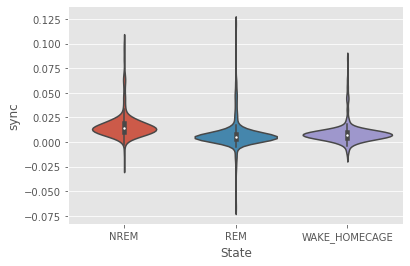

In [27]:
sns.violinplot(data = df,x = 'State',y = 'sync')

In [204]:
df = pd.to_numeric(df,errors='ignore')

TypeError: arg must be a list, tuple, 1-d array, or Series

In [181]:
a = a.T.drop_duplicates().T

In [185]:
pd.to_numeric(a,errors='ignore')

TypeError: arg must be a list, tuple, 1-d array, or Series

In [199]:
a.apply(pd.to_numeric, errors='ignore')

,State,cv,eib,sync
0,NREM,141.796021,0.523399,0.012565
1,NREM,141.872619,0.549983,0.010944
2,NREM,137.038892,0.540745,0.015841
3,NREM,136.815476,0.544589,0.018903
4,NREM,130.666131,0.541247,0.018614
...,...,...,...,...
77,WAKE_HOMECAGE,187.242261,0.445521,0.038049
78,WAKE_HOMECAGE,238.429288,0.380663,0.006154
79,WAKE_HOMECAGE,244.878502,0.366004,0.008299
80,WAKE_HOMECAGE,199.379824,0.411378,0.004071


In [157]:
sns.violinplot(data = a,x = 'State',y = 'sync')

TypeError: No loop matching the specified signature and casting was found for ufunc add

,State,cv,eib,sync
0,NREM,141.796021,0.523399,0.012565
1,NREM,141.872619,0.549983,0.010944
2,NREM,137.038892,0.540745,0.015841
3,NREM,136.815476,0.544589,0.018903
4,NREM,130.666131,0.541247,0.018614
...,...,...,...,...
77,WAKE_HOMECAGE,187.242261,0.445521,0.038049
78,WAKE_HOMECAGE,238.429288,0.380663,0.006154
79,WAKE_HOMECAGE,244.878502,0.366004,0.008299
80,WAKE_HOMECAGE,199.379824,0.411378,0.004071


In [132]:
a['State']

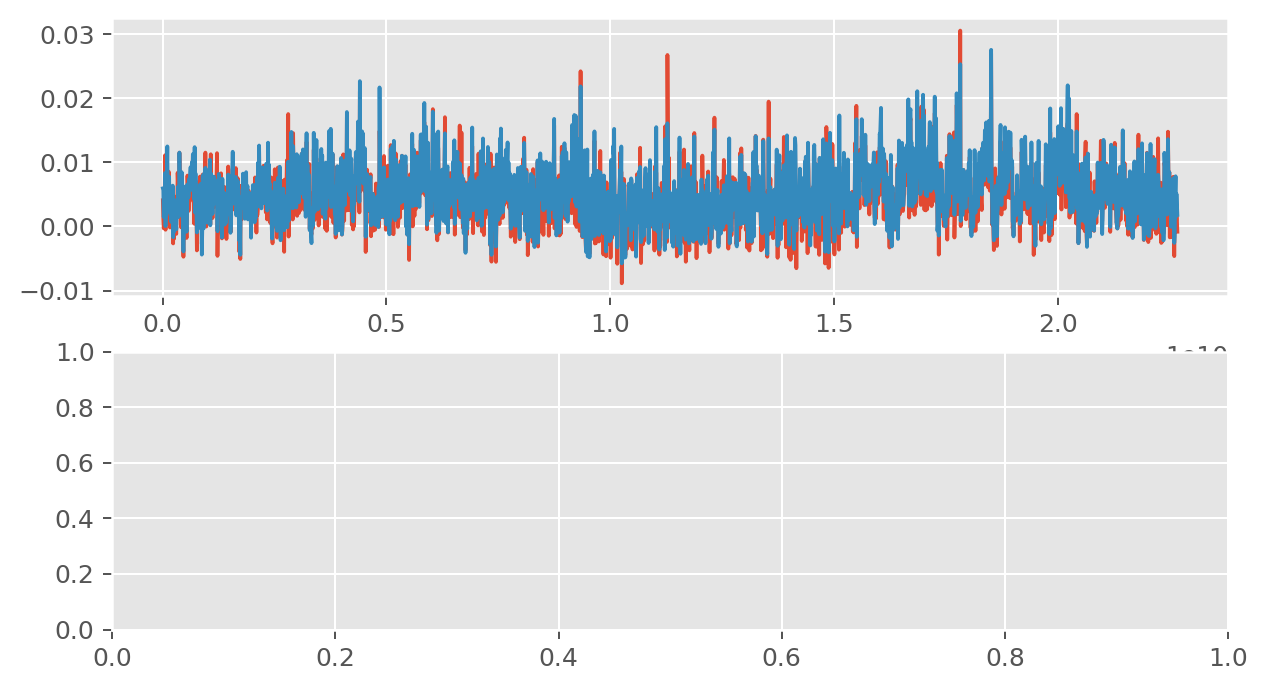

In [39]:
fig,ax = plt.subplots(2,1,figsize = (8,4.5),dpi = 180)
ax[0].plot(sync['Pyr'])
# ax[0].plot(sync['Int'])
ax[0].plot(sync['both'])

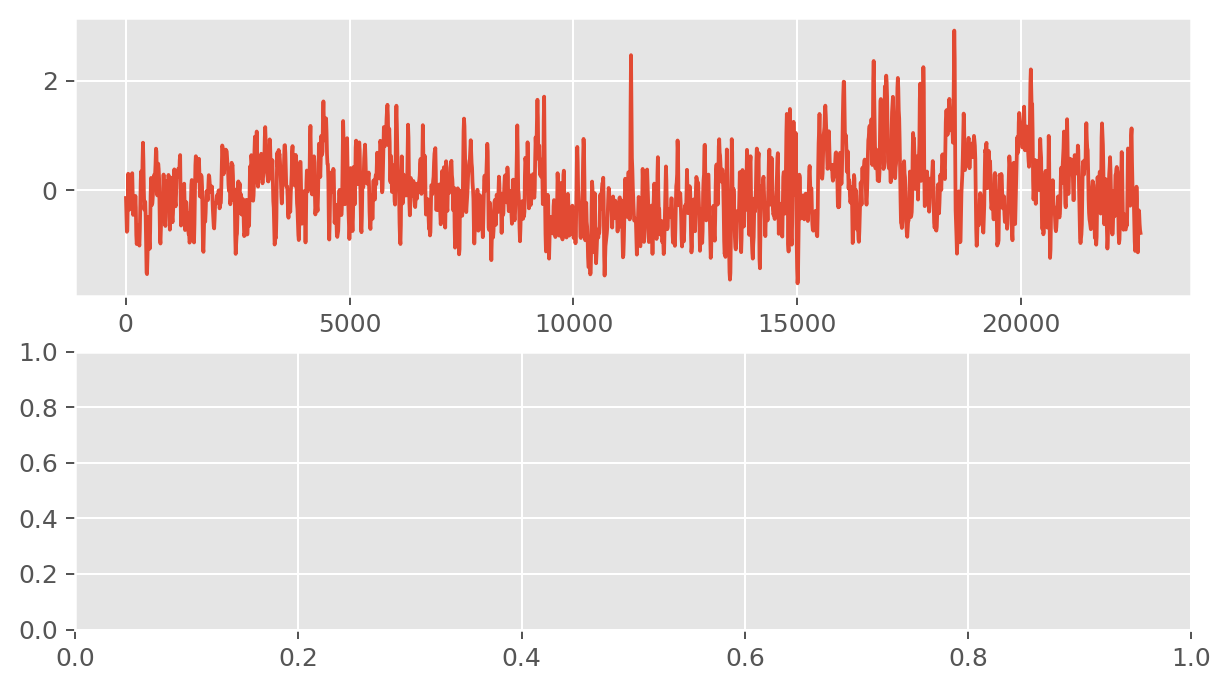

In [28]:
fig,ax = plt.subplots(2,1,figsize = (8,4.5),dpi = 180)
# ax[0].plot(df['Sync'].as_units('s'))
# ax[0].plot(df2['Sync'].as_units('s'))
ax[0].plot(df3['Sync'].as_units('s'))
# ax[1].plot(df2['Sync'].as_units('s')-df['Sync'].as_units('s'))

In [81]:
fig,ax = plt.subplots(1,1,figsize = (16,9),dpi = 180)
plt.plot(sync_z_smooth.as_units('s'))
for state,color in zip(['REM','NREM','WAKE_HOMECAGE'],['Orange','Grey','Green']):
    bk.plot.intervals(states[state],col = color,ax = ax)
plt.ylim(-3,3)
plt.xlabel('Time (s)')
plt.ylabel('Sync')
plt.savefig('/home/billel/pCloudDrive/IFM/work/sync_z_smooth.svg')

In [91]:
fig,ax = plt.subplots(1,1,figsize = (16,9),dpi = 180)
plt.plot(eib_z_smooth.as_units('s'))
for state,color in zip(['REM','NREM','WAKE_HOMECAGE'],['Orange','Grey','Green']):
    bk.plot.intervals(states[state],col = color,ax = ax)
plt.ylim(-3,3)
plt.xlabel('Time (s)')
plt.ylabel('Sync')
plt.savefig('/home/billel/pCloudDrive/IFM/work/eib_z_smooth.svg')

In [92]:
fig,ax = plt.subplots(1,1,figsize = (16,9),dpi = 180)
plt.plot(cv_z_smooth.as_units('s'))
for state,color in zip(['REM','NREM','WAKE_HOMECAGE'],['Orange','Grey','Green']):
    bk.plot.intervals(states[state],col = color,ax = ax)
plt.ylim(-3,3)
plt.xlabel('Time (s)')
plt.ylabel('Sync')
plt.savefig('/home/billel/pCloudDrive/IFM/work/cv_z_smooth.svg')

In [90]:
fig,ax = plt.subplots(1,1,figsize = (16,9),dpi = 180)
sns.violinplot(data = df, y = 'EIB',x = 'State')
plt.savefig('/home/billel/pCloudDrive/IFM/work/EIB_by_state.svg')

In [93]:
fig,ax = plt.subplots(1,1,figsize = (16,9),dpi = 180)
sns.violinplot(data = df, y = 'CV',x = 'State')
plt.savefig('/home/billel/pCloudDrive/IFM/work/CV_by_state.svg')

In [99]:
%matplotlib qt
sns.scatterplot(data = df,x = 'FR_Int',y = 'EIB',s = 5)
plt.xlim(-3,3)
plt.ylim(-3,3)

(-3.0, 3.0)

In [48]:
df = nts.TsdFrame(df.index.values,df)

In [52]:
import plotly.express as px
import pandas as pd

# Load the data into a DataFrame

# Make sure the 'time' column is in the correct date format
df['time'] = df.as_units('s').index.values

# Select only the columns that you want to plot
df_plot = df[['time', 'CV', 'EIB', 'Sync', 'FR_Pyr', 'FR_Int']]

# Create the plot
fig = px.line(df_plot, x='time', y=['CV', 'EIB', 'Sync', 'FR_Pyr', 'FR_Int'], title='Time Series Plot')

# Show the plot
fig.show()
fig.write_html('/home/billel/Documents/figure.html')